Get the per image normalized counts for validation data

In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import shutil
from scipy import ndimage
# from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [2]:
# load trained model here
TN_model = tf.keras.models.load_model('models/TN_model_with_new_data.h5')
# look at the input shape
TN_model.input

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_input')>

In [3]:
TN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                           

In [4]:
# image and density file location
file_path  = 'Preprocessed_valid_data/all_img_density_files/'

In [5]:
# contents here
folder_contents = os.listdir(file_path)
folder_contents.sort()

In [6]:
len(folder_contents)

64

In [7]:
# get only the image files
val_images = [file for file in folder_contents if file.split(".")[0][-3:] != 'map']
val_images.sort()

In [8]:
len(val_images)

32

In [9]:
%%time
# check the shapes of the image files
counter = 0
for file in val_images:
    load_file = np.load(file_path + '/' + file)
    counter = counter + 1
    print(counter, file, load_file.shape)

1 Block0204_2020_06_29.npy (1024, 768, 3)
2 Block0204_2020_07_01.npy (1024, 768, 3)
3 Block0204_2020_07_02.npy (1024, 768, 3)
4 Block0204_2020_07_06.npy (1024, 768, 3)
5 Block0204_2020_07_07.npy (1024, 768, 3)
6 Block0204_2020_07_08.npy (1024, 768, 3)
7 Block0204_2020_07_14.npy (1024, 768, 3)
8 Block0204_2020_07_16.npy (1024, 768, 3)
9 Block0204_2020_07_17.npy (1024, 768, 3)
10 Block0204_2020_07_20.npy (1024, 768, 3)
11 Block0204_2020_07_22.npy (1024, 768, 3)
12 Block0204_2020_07_23.npy (1024, 768, 3)
13 Block0204_2020_08_03.npy (768, 1024, 3)
14 Block0204_2020_08_04.npy (768, 1024, 3)
15 Block0204_2020_08_06.npy (768, 1024, 3)
16 Block0204_2020_08_07.npy (768, 1024, 3)
17 Block0204_2020_08_11.npy (768, 1024, 3)
18 Block0204_2020_08_12.npy (768, 1024, 3)
19 Block0204_2020_08_14.npy (768, 1024, 3)
20 Block0204_2020_08_15.npy (768, 1024, 3)
21 Block0204_2020_08_17.npy (768, 1024, 3)
22 Block0204_2020_08_18.npy (768, 1024, 3)
23 Block0204_2020_08_19.npy (768, 1024, 3)
24 Block0204_2020_08

In [10]:
# get the stacked test sub windows path
block_number = 'Block_24'
stacked_file_path = os.path.join('final_valid_sub_windows_and_counts/', block_number)
stacked_file_path

'final_valid_sub_windows_and_counts/Block_24'

In [11]:
# get the contents
contents_stacked = os.listdir(stacked_file_path)
contents_stacked.sort()

In [12]:
len(contents_stacked)

64

In [13]:
# get only the image files
images_stacked = [file for file in contents_stacked if file[:7] == 'val_ims']
images_stacked.sort()

In [14]:
len(images_stacked)

32

In [15]:
images_stacked[0]

'val_ims_Block0204_2020_06_29.npy'

In [16]:
images_stacked[0].split('val_ims_')[-1]

'Block0204_2020_06_29.npy'

In [17]:
# define a function to get the post-hoc prediction
def prediction_on_test_data(model, numpy_folder, v_stack_folder, selected_file, stride = 8, kernel_size = 32):
#     load the cnn model
    
# load the image data file
    load_image = np.load(numpy_folder + "/"+ selected_file)
    
    # get the image height
    img_height = load_image.shape[0]
    # get the image weight
    img_width = load_image.shape[1]

    selected_stacked_file = 'val_ims_' + selected_file
    all_test_sub_windows = np.load(v_stack_folder + "/"+ selected_stacked_file)

    # now, to get the predictions, pass the sub windows
    test_image_prediction = model.predict(all_test_sub_windows)
    
    # density map
    Density_map = np.zeros((img_height, img_width))

    # counts map
    counts_map = np.zeros((img_height, img_width))
    
    # now, for every window, we will keep adding the values together and also add the counts
    counter = 0
#     need a counter to move into each predicted value in the pred values list
    for ii in range(0, img_height, stride):
        for jj in range(0, img_width, stride):
#         operations for density map
#             get the window of interest
            new_window = Density_map[ii:ii + kernel_size,jj:jj+kernel_size]
#     fill each with the value c_k
            counts_window = np.full((new_window.shape[0], new_window.shape[1]), test_image_prediction[counter])
#     get the shapes of this new window
            cw_height = counts_window.shape[0]
            cw_width = counts_window.shape[1]
#         Do c_k/r_2
            counts_window_new = counts_window/(cw_height*cw_width)
#     This is the value in the window now
            value_window = counts_window_new
#     place the values in the corrsponding area of the density map
            Density_map[ii:ii + kernel_size,jj:jj+kernel_size] = new_window + value_window

#         Let's now focus on capturing the counts of the windows
            new_window_c = counts_map[ii:ii + kernel_size,jj:jj+kernel_size]
#     get the counts area
            count = np.ones((new_window_c.shape[0], new_window_c.shape[1]))
#     keep adding the counts to reflect the addition of densities
            counts_map[ii:ii + kernel_size,jj:jj+kernel_size] = new_window_c + count
#     increase the counter
            counter = counter + 1
            
#         get the normalized count
    normalized_counts = np.divide(Density_map, counts_map)
    
#     entire count on the test set
    pred_on_test = np.sum(normalized_counts)
    
#     return the predicted value
    return(pred_on_test, normalized_counts, selected_file)

In [18]:
%%time
# get the predictions for valid data

# save density map path
dense_path = "predicted_count_maps_for_valid_files/Block_24"

final_values_preds_names = []
for file in val_images:
    name = file
    preds_value, norm_counts, _ = prediction_on_test_data(TN_model, file_path, stacked_file_path, file, stride = 8, kernel_size = 32)
    # save the normalized density maps
    np.save(dense_path + '/' + file.split('.')[0] + '_' +  '_norm_map_TN.npy', norm_counts)
        # normalized_pred_maps.append(norm_counts)
    final_values_preds_names.append((name, preds_value))

CPU times: user 36.9 s, sys: 8.77 s, total: 45.6 s
Wall time: 46.9 s


In [19]:
# create a dataframe with the predicted values
Predicted_values_df = pd.DataFrame(final_values_preds_names, columns = ['Image_name', 'Predicted_count'])

In [20]:
Predicted_values_df.head()

,Image_name,Predicted_count
0,Block0204_2020_06_29.npy,2.103025
1,Block0204_2020_07_01.npy,3.598690
2,Block0204_2020_07_02.npy,7.005647
3,Block0204_2020_07_06.npy,9.229449
4,Block0204_2020_07_07.npy,12.557514


In [21]:
Predicted_values_df.shape

(32, 2)

In [22]:
# import the true validation counts
True_valid_counts_df = pd.read_csv("True_tassel_counts/all_data/final_valid_true_counts.csv")

In [23]:
True_valid_counts_df.shape

(32, 2)

In [24]:
True_valid_counts_df.head()

,name,true_count
0,Block0204_2020_06_29,0
1,Block0204_2020_07_01,0
2,Block0204_2020_07_02,0
3,Block0204_2020_07_06,0
4,Block0204_2020_07_07,2


In [25]:
rmse = np.sqrt(mean_squared_error(True_valid_counts_df['true_count'],Predicted_values_df['Predicted_count'] ))
mae = mean_absolute_error(True_valid_counts_df['true_count'],Predicted_values_df['Predicted_count'] )
R2 = r2_score(True_valid_counts_df['true_count'],Predicted_values_df['Predicted_count'] )
corr = pearsonr(True_valid_counts_df['true_count'],Predicted_values_df['Predicted_count'] )

In [26]:
rmse, mae, R2, corr

(11.239783861903963,
 9.199676612377154,
 0.3807188920145894,
 PearsonRResult(statistic=0.7719935402661476, pvalue=2.2882417862306065e-07))

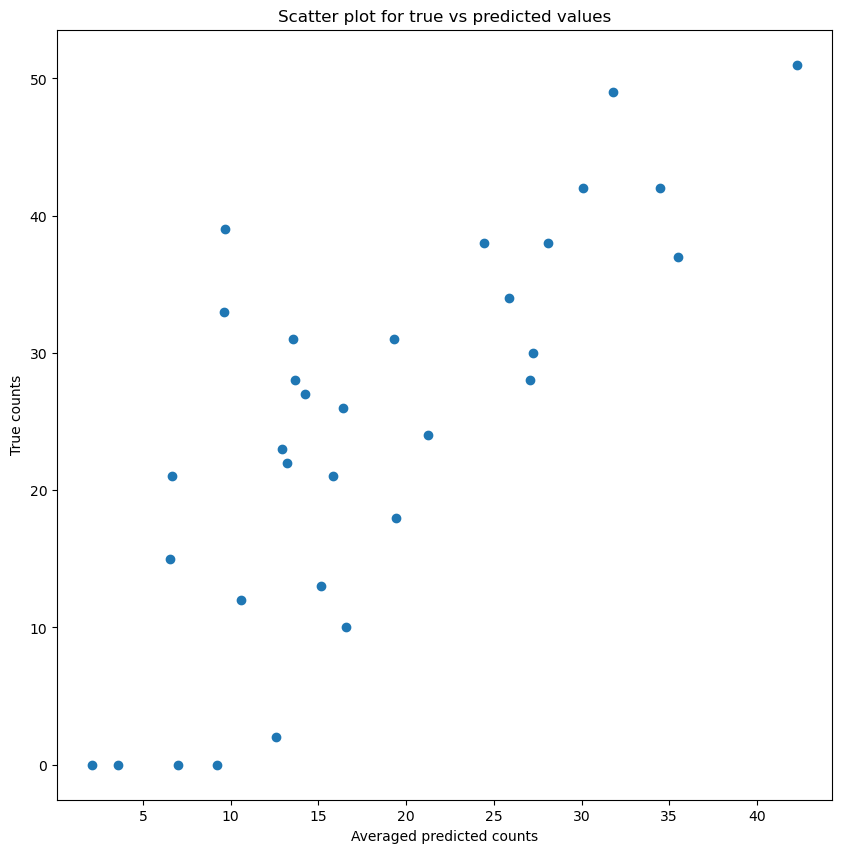

In [27]:
plt.figure(figsize = (10,10))
plt.scatter( Predicted_values_df['Predicted_count'], True_valid_counts_df['true_count'])
plt.title("Scatter plot for true vs predicted values")
plt.xlabel("Averaged predicted counts")
plt.ylabel("True counts")
plt.show()

In [28]:
# concatenate the true and predicted counts and save these for later use
final_validation_df = pd.concat((True_valid_counts_df, Predicted_values_df['Predicted_count']), axis = 1)

In [29]:
final_validation_df.head()

,name,true_count,Predicted_count
0,Block0204_2020_06_29,0,2.103025
1,Block0204_2020_07_01,0,3.598690
2,Block0204_2020_07_02,0,7.005647
3,Block0204_2020_07_06,0,9.229449
4,Block0204_2020_07_07,2,12.557514


In [30]:
final_validation_df.shape

(32, 3)

In [31]:
# save this dataframe for calibration models
final_validation_df.to_csv("True_tassel_counts/validation_true_and_predicted_counts.csv", index = False)